In [1]:
import numpy as np
import pprint
import mne
import pyxdf
import matplotlib.pyplot as plt
from pathlib import Path

from scipy import signal

import util.preprocess_util as preprocess
import util.analysis_util as analysis
import util.visualise_util as visualise
from util.data_util import EEG_Dataset, get_trials, get_good_trials
from models.lda import *

%load_ext autoreload
%autoreload 2

# Load data from xdf file

From the Unicorn Stream
- `eeg_data`: the 8 channel raw eeg data
- `eeg_timestamps`: timestamp for each eeg sample
- `fs`: the sampling frequency

From the Open Vibe Marker Stream
- `event_codes`: array of codes sent to the marker stream at the start of each event 
- `event_time_stamps`: array of timestamps signifying the start of each event


In [2]:
DATA_DIR = Path('./data')
DATA_FILE_NAME = 'Sandra_MI_1h.xdf'
DATA_FILE = DATA_DIR / DATA_FILE_NAME

dataset = EEG_Dataset(DATA_FILE)

Data succesfullly loaded from data/Sandra_MI_1h.xdf


In [3]:
# Extract the EEG data
eeg_data = dataset.eeg_data
eeg_timestamps = dataset.eeg_timestamps
fs = dataset.fs

print(f"EEG data shape: {eeg_data.shape}")
print(f'Sampling Frequency: {fs}')

# Extract the marker stream data
event_codes = dataset.event_codes
event_labels = dataset.event_labels
label2code = dataset.label2code
label2code['idle'] = 8
label2code['mi'] = 9
print(f'Total number of events: {event_codes.shape[0]}')
pprint.pprint(f'Label->Code: \n{label2code}')
print(f'Event code for left MI: {label2code["imagery_handL"]}')
print(f'Event code for right MI: {label2code["imagery_handR"]}')
print(f'Count left MI events: {np.sum(event_codes == label2code["imagery_handL"])}')
print(f'Count right MI events: {np.sum(event_codes == label2code["imagery_handR"])}')

EEG data shape: (8, 1023780)
Sampling Frequency: 250
Total number of events: 1213
('Label->Code: \n'
 "{'beep': 0, 'cue_no_blink': 1, 'imagery_no_blink': 2, 'break': 3, "
 "'cue_handR': 4, 'imagery_handR': 5, 'cue_handL': 6, 'imagery_handL': 7, "
 "'idle': 8, 'mi': 9}")
Event code for left MI: 7
Event code for right MI: 5
Count left MI events: 200
Count right MI events: 200


# Build an event time-series/stream

Create a time series from the event codes which is the same length as the EEG data

In [4]:
eeg_timestamps, event_timestamps, event_timeseries = dataset.build_event_timeseries()

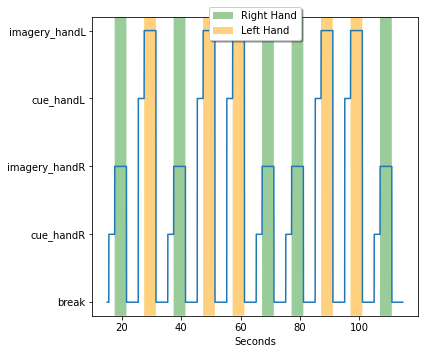

In [5]:
visualise.plot_events(
    eeg_timestamps,
    event_timeseries,
    fs,
    label2code
)

# Preprocess EEG data

## 1. Rereference the EEG data

In [6]:
# Rereference according to the mean
eeg_data = eeg_data - np.mean(eeg_data, axis=0)

## 2. Filter EEG data

In [7]:
lf = 8
hf = 16
nf = 50

# Design notch filter
b, a = signal.iirnotch(w0=nf, Q=7, fs=fs)
freq, h = signal.freqz(b, a, fs = fs)

# Apply notch and bandpass filters
eeg_notched = signal.filtfilt(b, a, eeg_data, axis=1)
eeg_notched_bp = preprocess.bandpass(eeg_notched, lf=lf, hf=hf, fs=fs, ftype='butter')

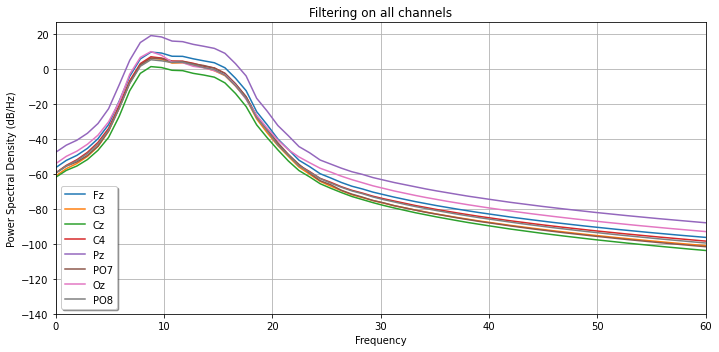

In [8]:
plt.figure(figsize=(10,5))
plt.title(f'Filtering on all channels')

for i in range(eeg_data.shape[0]):
    plt.psd(eeg_notched_bp[i], Fs=fs, label=f'{preprocess.channel2name(i)}')

plt.tight_layout()
plt.legend(loc='lower left', shadow=True)
plt.xlim([0,60])
plt.show()

## 3. Normalise EEG data

In [9]:
eeg_notched_bp_norm = preprocess.normalise_eeg(eeg_notched_bp)

# Split into trials

In [10]:
EEG = eeg_notched_bp_norm.copy()
event_onsets = event_timestamps.copy()
classes = ['imagery_handL', 'imagery_handR', 'cue_handL', 'cue_handR']
class_codes = [label2code[code] for code in classes]
nclasses = len(classes)
nchannels = EEG.shape[0]

# Print some information
print('Sample rate:', fs)
print('Number of EEG channels:', nchannels)
print('Channel names:', [preprocess.channel2name(channel) for channel in range(EEG.shape[0])])

print('\nNumber of classes:', nclasses)
print('Class labels used to extract trials:', classes)

print('\nNumber of events:', len(event_onsets))
print('All event codes:', np.unique(event_codes))
print('Class codes:', class_codes)

Sample rate: 250
Number of EEG channels: 8
Channel names: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']

Number of classes: 4
Class labels used to extract trials: ['imagery_handL', 'imagery_handR', 'cue_handL', 'cue_handR']

Number of events: 1213
All event codes: [0 1 2 3 4 5 6 7]
Class codes: [7, 5, 6, 4]


In [11]:
mi_window = [0.5, 2.5]
mi_nsamples = len(np.arange(int(mi_window[0]*fs), int(mi_window[1]*fs)))

idle_window = [0.25, 1.75]
idle_nsamples = len(np.arange(int(idle_window[0]*fs), int(idle_window[1]*fs)))

class_nsamples = [mi_nsamples, mi_nsamples, idle_nsamples, idle_nsamples]

trials = get_trials(
    eeg_data=EEG,
    event_time_series=event_timeseries,
    class_labels=classes,
    label2code=label2code,
    nsamples=class_nsamples
)

for key, val in trials.items():
    print(f'{key}: {val.shape}')

imagery_handL: (8, 500, 200)
imagery_handR: (8, 500, 200)
cue_handL: (8, 375, 200)
cue_handR: (8, 375, 200)


# Some statistical Analysis to remove noisy trials

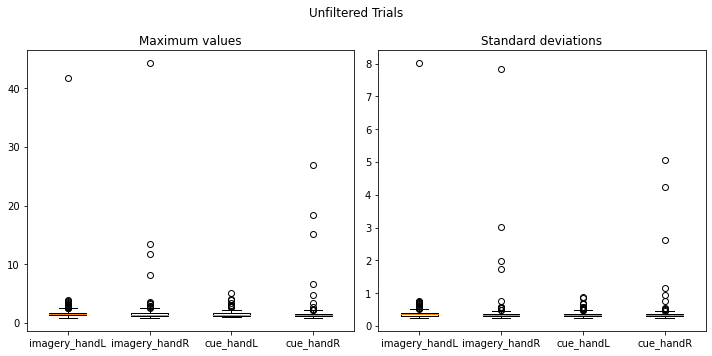

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Unfiltered Trials')

axs[0].set_title('Maximum values')
axs[0].boxplot([ trials[cl].max(axis = (0,1)) for cl in classes ], labels=classes)

axs[1].set_title('Standard deviations')
axs[1].boxplot([ trials[cl].std(axis = (0,1)) for cl in classes ], labels=classes)

plt.tight_layout()
plt.show()

In [13]:
# Set the upper limit on the maxval and std dev as 2*(3rd quartile)

upperlimit_max = {}
for cl in classes:
    upperlimit_max[cl] = np.percentile(trials[cl].max(axis = (0,1)), [75])[0] * 1.5

upperlimit_std = {}
for cl in classes:
    upperlimit_std[cl] = np.percentile(trials[cl].std(axis = (0,1)), [75])[0] * 1.5

upperlimit_std

{'imagery_handL': 0.5966861295360828,
 'imagery_handR': 0.5607748092425172,
 'cue_handL': 0.5647089798842686,
 'cue_handR': 0.5537755257558372}

In [14]:
good_trials = get_good_trials(
    trials=trials,
    nchannels=nchannels,
    class_nsamples=class_nsamples,
    upperlimit_std=upperlimit_std,
    upperlimit_max=upperlimit_max
)

for cl in classes:
    print(f'{cl} has {good_trials[cl].shape} non noisy trials')


imagery_handL has (8, 500, 187) non noisy trials
imagery_handR has (8, 500, 190) non noisy trials
cue_handL has (8, 375, 189) non noisy trials
cue_handR has (8, 375, 192) non noisy trials


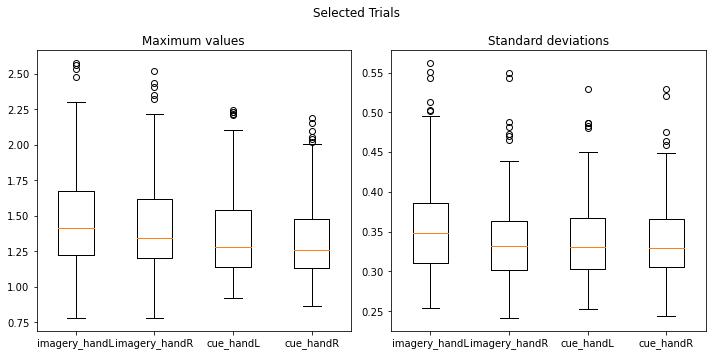

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Selected Trials')

axs[0].set_title('Maximum values')
axs[0].boxplot([ good_trials[cl].max(axis = (0,1)) for cl in classes ], labels=classes)

axs[1].set_title('Standard deviations')
axs[1].boxplot([ good_trials[cl].std(axis = (0,1)) for cl in classes ], labels=classes)

plt.tight_layout()
plt.show()

# Combine MI trials

If you want to classify idle/MI this is useful

In [16]:
good_trials['mi'] = np.concatenate([
    good_trials['imagery_handL'][:,:,:],
    good_trials['imagery_handR'][:,:,:]
], axis=2)

print(good_trials['mi'].shape)

(8, 500, 377)


# Combine Idle Trials

If you are classifying idle/left/right only take half of the idle data so that the dataset is balanced.

In [17]:
good_trials['idle'] = np.concatenate([
    good_trials['cue_handL'][:,:,-90:],
    good_trials['cue_handR'][:,:,-90:]
], axis=2)

good_trials['idle'] = np.concatenate([
    good_trials['cue_handL'][:,:,:],
    good_trials['cue_handR'][:,:,:]
], axis=2)


print(good_trials['idle'].shape)

(8, 375, 381)


In [18]:
# Some visualisation

# plt.rcParams.update({'font.size': 18})

# trials_bp = {}
# for cl in classes:
#     freqs, bandpower = analysis.bandpower(good_trials[cl], fs, band=band)
#     trials_bp[cl] = bandpower

# analysis.plot_bandpower(
#     trials_bp, 
#     classes, 
#     title=f'{band} Hz Bandpower',
#     pretty_labels=['Left','Right', 'Idle'])

# nchannels = trials[classes[0]].shape[0]

# plt.figure(figsize=(12,5))
# for i, cl in enumerate(classes[:2]):
#     color_variant = i/len(classes)
#     plt.boxplot(
#         [trials_bp[cl][ch,:] for ch in range(nchannels)],
#         positions=np.arange(0,nchannels)*nclasses-i*0.8,
#         widths=0.6,
#         patch_artist=True,
#         boxprops=dict(facecolor=(color_variant,0.2,0.2,1), color='orange'),
#         labels=['' for i in range(8)]
#     )
# i +=1
# plt.boxplot(
#     [trials_bp[cl][ch,:] for ch in range(nchannels)],
#     positions=np.arange(0,nchannels)*nclasses-i*0.8,
#     widths=0.6,
#     patch_artist=True,
#     boxprops=dict(facecolor=(color_variant,0.2,0.2,1), color='orange'),
#     labels=['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
# )
# plt.legend(classes)
# plt.show()

# Set Up Trials for Training

In [19]:
def build_sklearn_train_data(train, label2code, nchannels, classes):
    # Build sk-learn compatible matrices
    X_train = np.empty([nchannels,0])
    y_train = np.array([])
    for cl in classes:
        X_train = np.concatenate([X_train, train[cl]], axis=1)
        y_train = np.concatenate([y_train, np.ones(train[cl].shape[1]) * label2code[cl]], axis=0)

    X_train =  X_train.T

    return X_train, y_train

def build_sklearn_test_data(test, label2code, nchannels, classes):
    # Build sk-learn compatible matrices
    X_test = np.empty([nchannels,0])
    y_test = np.array([])
    for cl in classes:
        X_test = np.concatenate([X_test, test[cl]], axis=1)
        y_test = np.concatenate([y_test, np.ones(test[cl].shape[1]) * label2code[cl]], axis=0)
    
    X_test =  X_test.T

    return X_test, y_test

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as skLDA
from sklearn.svm import SVC as skSVM
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as skQDA
from sklearn.neural_network import MLPClassifier as skMLP
from sklearn.metrics import confusion_matrix

In [95]:
# ----------------------------------------------------------------
# H-PARAMS
# ----------------------------------------------------------------
multistage = True

# classes = ['imagery_handL', 'imagery_handR']
classes = ['imagery_handL', 'imagery_handR', 'idle']
# classes = ['idle', 'mi']
nclasses = len(classes)

nfolds = 5

band = [8, 16]
band = [10, 13]
channels = [1,2,3]
# channels = [1,2,3,4,5,6,7]
nchannels = len(channels)

# imi_classifier = skLDA()
# lr_classifier = skLDA()
imi_classifier = skQDA()
lr_classifier = skQDA()
# classifier = skLDA()
# classifier = skSVM(gamma='auto', kernel='linear')
# classifier = skQDA()
# classifier = skMLP(random_state=1, max_iter=500, )

apply_csp = False
components = np.array([0,-1])           # Select components as features for classification
feature = 'bandpower'

if apply_csp:
    channels = [0, 1, 2, 3, 4, 5, 6, 7]
    nchannels = len(channels)
    assert feature in ['bandpower', 'logvar']
# ----------------------------------------------------------------

# Print some information
print('Classes:', classes)
print('Shape of EEG:', EEG.shape)
print('Sample rate:', fs)
print('Number of channels:', nchannels)
print('Frequency band for bandpower:', band)

Classes: ['imagery_handL', 'imagery_handR', 'idle']
Shape of EEG: (8, 1023780)
Sample rate: 250
Number of channels: 3
Frequency band for bandpower: [10, 13]


## Classify

In [96]:
debug = False


In [97]:
# Find size of cross val datasets
test_set_shapes = {}
train_set_shapes = {}
for cl in classes:
    test_set_shapes[cl] = int(good_trials[cl].shape[2] / nfolds)
    train_set_shapes[cl] = good_trials[cl].shape[2] - test_set_shapes[cl]


# Places to plot/view the results
accuracies = np.zeros(nfolds)
fprs = np.zeros(nfolds)
class_accuracies = {}
confusion_matrices = {}

# Run cross validation for k folds
for i in range(nfolds):    
    train = {}
    test = {}
    
    # Split dataset
    for cl in classes:
        ntest = test_set_shapes[cl]
        train[cl] = np.concatenate(
            [good_trials[cl][:,:,:i*ntest], 
            good_trials[cl][:,:,(i+1)*ntest:]], axis=2)
        test[cl] = good_trials[cl][:,:,i*ntest:(i+1)*ntest]

    if debug:
        print('\nTrain dataset sizes')
        for cl in classes:
            print(cl, train[cl].shape)

    # ----------------
    # Stage 1
    # ----------------
    classes_st1 = ['mi', 'idle']
    train_st1 = {}
    train_st1['mi'] = np.concatenate([
        train['imagery_handL'],
        train['imagery_handR']
    ], axis=2)
    train_st1['idle'] = train['idle']

    # Bandpower of train set -> train_st1
    for cl in classes_st1:
        _, bandpower = analysis.bandpower(train_st1[cl], fs, band)
        train_st1[cl] = bandpower[channels,:]
        
    if debug:
        print('\nStage 1 Train dataset sizes')
        for cl in classes_st1:
            print(cl, train_st1[cl].shape)
    
    # Build sk-learn compatible matrices st1
    X_train_st1, y_train_st1= build_sklearn_train_data(
        train_st1, label2code, nchannels, classes_st1
    )

    # LDA classifier st1
    imi_classifier.fit(X_train_st1, y_train_st1)

    # ----------------
    # Stage 2
    # ----------------
    # Build stage 2 training dicts
    classes_st2 = ['imagery_handL', 'imagery_handR']

    train_st2 = {
        'imagery_handL': train['imagery_handL'],
        'imagery_handR': train['imagery_handR']
    }

    if apply_csp:
        feature_used = 'CSP'

        # CSP
        train_csp = preprocess.CSP(train, classes_st2, 500, nchannels)
        W = train_csp.get_W()
        train_st2 = train_csp.get_csp_trials()

        # Select CSP components
        for cl in classes_st2:
            train_st2[cl] = train_st2[cl][components,:,:]
            train_st2[cl] = train_st2[cl][components,:,:]

        if debug:
            print(f'\nStage 2 Train dataset sizes (post {feature_used} with components: {components})')
            for cl in classes_st2:
                print(cl, train_st2[cl].shape)

        # Feature extraction
        if feature == 'bandpower':
            # Bandpower
            for cl in classes_st2:
                _, bandpower = analysis.bandpower(train_st2[cl], fs, band)
                train_st2[cl] = bandpower
                # _, bandpower = analysis.bandpower(test[cl], fs, band)
                # test[cl] = bandpower
        elif feature == 'logvar':
            # Logvar
            for cl in classes_st2:
                train_st2[cl] = analysis.logvar(train_st2[cl])
                # test[cl] = analysis.logvar(test[cl])
        
        if debug:
            print(f'\nStage 2 Train dataset sizes (post {feature_used}:{feature} with components: {components})')
            for cl in classes_st2:
                print(cl, train_st2[cl].shape)
        
        # Build sk-learn compatible matrices
        X_train_st2, y_train_st2 = build_sklearn_train_data(
                train_st2, label2code, len(components), classes_st2)

    else:
        # USE BANDPOWER ONLY (stage 2)
        feature_used = 'bandpower'

        # Bandpower of train set -> train_st2
        for cl in classes_st2:
            _, bandpower = analysis.bandpower(train_st2[cl], fs, band)
            train_st2[cl] = bandpower[channels,:]

        # Build sk-learn compatible matrices
        X_train_st2, y_train_st2 = build_sklearn_train_data(
                train_st2, label2code, nchannels, classes_st2)

    if debug:
        print(f'\nStage 2 Train dataset sizes (post {feature_used})')
        for cl in classes_st2:
            print(cl, train_st2[cl].shape)


    # LDA classifier st1
    lr_classifier.fit(X_train_st2, y_train_st2)


    # ----------------
    # Testing stage 1
    # ----------------
    test_st1 = {}
    for cl in classes:
        _, bandpower = analysis.bandpower(test[cl], fs, band)
        test_st1[cl] = bandpower[channels,:]
    
    if debug:
        print('\nStage 1 Test dataset sizes (post bandpass)')
        for cl in classes:
            print(cl, test_st1[cl].shape)
    
    X_test_st1, y_test_st1 = build_sklearn_test_data(
        test_st1, label2code, nchannels, classes
    )

    # Predict
    y_pred_st1 = imi_classifier.predict(X_test_st1)
    
    # Number of correct  and incorrect idle predictions
    correct_idle = np.sum(np.logical_and(
        y_pred_st1 == y_test_st1, 
        y_pred_st1 == label2code['idle']))
    incorrect_idle = np.sum(np.logical_and(
        y_pred_st1 != y_test_st1, 
        y_pred_st1 == label2code['idle']))
    
    # Find indexes where stage 1 predicted MI and it is actually MI (stage 2 automatically gets any idle trials passed to it wrong)
    idxs = np.where(np.logical_and(
        y_pred_st1 == label2code['mi'], 
        y_test_st1 != label2code['idle']))[0]
    
    FP1 = np.sum(np.logical_and(
        y_pred_st1 == label2code['mi'], 
        y_test_st1 == label2code['idle']))
    # ----------------
    # Testing stage 2
    # ----------------
    classes_test_st2 = ['imagery_handL', 'imagery_handR']
    test_st2 = {
        'imagery_handL': test['imagery_handL'][:,:, idxs[idxs < test['imagery_handL'].shape[2]]],
        'imagery_handR': test['imagery_handR'][:,:, idxs[idxs >= test['imagery_handR'].shape[2]] - test['imagery_handR'].shape[2] ]
    }
    
    if apply_csp:
        feature_used = 'CSP'

        # Apply CSP from training
        test_csp = preprocess.CSP(test_st2, classes_test_st2, 500, nchannels, W=W)
        test_st2 = test_csp.get_csp_trials()

        # Select CSP components
        for cl in classes_test_st2:
            test_st2[cl] = test_st2[cl][components,:,:]
            test_st2[cl] = test_st2[cl][components,:,:]

        if debug:
            print(f'\nStage 2 Test dataset sizes (post {feature_used} with components: {components})')
            for cl in classes_st2:
                print(cl, test_st2[cl].shape)

        # Feature extraction
        if feature == 'bandpower':
            # Bandpower
            for cl in classes_test_st2:
                _, bandpower = analysis.bandpower(test_st2[cl], fs, band)
                test_st2[cl] = bandpower
        elif feature == 'logvar':
            # Logvar
            for cl in classes_st2:
                test_st2[cl] = analysis.logvar(test_st2[cl])
        
        if debug:
            print(f'\nStage 2 Train dataset sizes (post {feature_used}:{feature} with components: {components})')
            for cl in classes_test_st2:
                print(cl, test_st2[cl].shape)
        
        X_test_st2, y_test_st2 = build_sklearn_test_data(
            test_st2, label2code, len(components), classes_test_st2
        )

    else:
        feature_used = 'bandpower'
        for cl in classes_test_st2:
            _, bandpower = analysis.bandpower(test_st2[cl], fs, band)
            test_st2[cl] = bandpower[channels,:]
        
        X_test_st2, y_test_st2 = build_sklearn_test_data(
            test_st2, label2code, nchannels, classes_test_st2
        )
    
    if debug:
        print(f'\nStage 2 Test dataset sizes (post {feature_used})')
        for cl in classes_test_st2:
            print(cl, test_st2[cl].shape)
        print(f'X Test shape {X_test_st1.shape} reduced to {X_test_st1[idxs,:].shape}')
    
    # Predict
    y_pred_st2 = lr_classifier.predict(X_test_st2)

    # Count correct predictions
    correct_l = np.sum(np.logical_and(
        y_pred_st2 == y_test_st2, 
        y_pred_st2 == label2code['imagery_handL']))
    correct_r = np.sum(np.logical_and(
        y_pred_st2 == y_test_st2, 
        y_pred_st2 == label2code['imagery_handR']))
    
    FP_l = np.sum(np.logical_and(
        y_pred_st2 == label2code['imagery_handL'],
        y_pred_st2 != y_test_st2))
    
    FP_r = np.sum(np.logical_and(
        y_pred_st2 == label2code['imagery_handR'],
        y_pred_st2 != y_test_st2))

    if debug:
        print(f'Correct: I:{correct_idle}, L:{correct_l}, R:{correct_r}')
        print(f'Incorrect: I:{incorrect_idle}, L:{FP_l}, R:{FP_r}')
        print(f'False positives: sum(Mw:{FP1}, Lw:{FP_l}, Rw:{FP_r}) = {FP_l + FP_r + FP1}')
        print(f'Ic + Iw + Lc + Lw + Rc + Rw + Mw = {correct_idle + incorrect_idle + correct_l + FP_l + correct_r + FP_r + FP1}')
        print(f'FPR: {(FP_l + FP_r + FP1) / y_test_st1.size}')

    fprs[i] = (FP_l + FP_r + FP1) / y_test_st1.size
    accuracies[i] = (correct_idle + correct_l + correct_r) / y_test_st1.size
    class_accuracies[i] = {
        'imagery_handL': correct_l / np.sum(y_test_st1 == label2code['imagery_handL']),
        'imagery_handR': correct_r / np.sum(y_test_st1 == label2code['imagery_handR']),
        'idle': correct_idle / np.sum(y_test_st1 == label2code['idle'])
    }
    

In [98]:
av_class_accuracy = {}
for i in range(nfolds):
    for cl in classes:
        if cl in av_class_accuracy:
            av_class_accuracy[cl] += class_accuracies[i][cl]
        else:
            av_class_accuracy[cl] = class_accuracies[i][cl]

for k,v in av_class_accuracy.items():
    av_class_accuracy[k] = v/nfolds

print(av_class_accuracy)

tex_row = f'{channels} & {band} & '
for k,v in av_class_accuracy.items():
    tex_row = ''.join([tex_row, f'{v:.2}', ' & '])

print(tex_row)

{'imagery_handL': 0.14594594594594595, 'imagery_handR': 0.6263157894736843, 'idle': 0.41052631578947363}
[1, 2, 3] & [10, 13] & 0.15 & 0.63 & 0.41 & 


In [99]:
fprs.mean()

0.48741721854304637

In [75]:
band

[10, 13]

In [60]:
idxs[idxs > test['imagery_handR'].shape[2]]

array([39, 41, 42, 43, 44, 45, 46, 50, 53, 54, 55, 58, 60, 63, 65, 68, 69,
       70, 71, 73, 74])

In [61]:
for k,v in test.items():
    print(k, v.shape)

imagery_handL (8, 500, 37)
imagery_handR (8, 500, 38)
idle (8, 375, 76)


In [62]:
idxs[idxs > test['imagery_handR'].shape[2]] - test['imagery_handR'].shape[2]

array([ 1,  3,  4,  5,  6,  7,  8, 12, 15, 16, 17, 20, 22, 25, 27, 30, 31,
       32, 33, 35, 36])

In [63]:
idxs.shape

(46,)

In [64]:
break

SyntaxError: 'break' outside loop (<ipython-input-64-6aaf1f276005>, line 4)

In [39]:
# # Feature extraction
#     if apply_csp == True:
#         # CSP
#         train_csp = preprocess.CSP(train, classes, class_nsamples[0], nchannels)
#         train = train_csp.get_csp_trials()
#         W = train_csp.get_W()
#         test_csp = preprocess.CSP(test, classes, class_nsamples[0], nchannels, W=W)
#         test = test_csp.get_csp_trials()

#         if feature == 'bandpower':
#             # Bandpower
#             for cl in classes:
#                 _, bandpower = analysis.bandpower(train[cl], fs, band)
#                 train[cl] = bandpower
#                 _, bandpower = analysis.bandpower(test[cl], fs, band)
#                 test[cl] = bandpower
#         elif feature == 'logvar':
#             # Logvar
#             for cl in classes:
#                 train[cl] = analysis.logvar(train[cl])
#                 test[cl] = analysis.logvar(test[cl])
#     else:
#         # Bandpower only
#         for cl in classes:
#             _, bandpower = analysis.bandpower(train[cl], fs, band)
#             train[cl] = bandpower[channels,:]
#             _, bandpower = analysis.bandpower(test[cl], fs, band)
#             test[cl] = bandpower[channels,:]
    
#     if multistage:
#         # Build stage 1 training dicts
#         train_st1, test_st1 = {},{}
        
#         train_st1['mi'] = np.concatenate([
#             train['imagery_handL'][:,:],
#             train['imagery_handR'][:,:]
#         ], axis=1)
#         train_st1['idle'] = train['idle']

#         # Build sk-learn compatible matrices st1
#         X_train_st1, y_train_st1= build_sklearn_train_data(
#             train_st1, label2code, nchannels, ['idle', 'mi']
#         )

#         # LDA classifier st1
#         imi_classifier.fit(X_train_st1, y_train_st1)

#         # Build stage 2 training dicts
#         train_st2 = {
#             'imagery_handL': train['imagery_handL'],
#             'imagery_handR': train['imagery_handR']
#         }

#         # Build sk-learn compatible matrices
#         X_train_st2, y_train_st2 = build_sklearn_train_data(
#             train_st2, label2code, nchannels, ['imagery_handL', 'imagery_handR']
#         )

#         # LDA classifier st1
#         lr_classifier.fit(X_train_st2, y_train_st2)

#         X_test, y_test = build_sklearn_train_data(
#             test, label2code, nchannels, ['imagery_handL', 'imagery_handR', 'idle']
#         )

#         # Testing
#         y_pred_st1 = imi_classifier.predict(X_test)
#         correct_idle = np.sum(np.logical_and(
#             y_pred_st1 == y_test, 
#             y_pred_st1 == label2code['idle']))
#         idxs = np.where(np.logical_and(
#             y_pred_st1 == label2code['mi'], 
#             y_test != label2code['idle']))[0]
        
#         y_pred_st2 = lr_classifier.predict(X_test[idxs,:])
#         correct_l = np.sum(np.logical_and(
#             y_pred_st2 == y_test[idxs], 
#             y_pred_st2 == label2code['imagery_handL']))
#         correct_r = np.sum(np.logical_and(
#             y_pred_st2 == y_test[idxs], 
#             y_pred_st2 == label2code['imagery_handR']))
        
#         accuracies[i] = (correct_idle + correct_l + correct_r) / y_test.size
#         class_accuracies[i] = {
#             'imagery_handL': correct_l / np.sum(y_test == label2code['imagery_handL']),
#             'imagery_handR': correct_r / np.sum(y_test == label2code['imagery_handR']),
#             'idle': correct_idle / np.sum(y_test == label2code['idle'])
#         }

IndentationError: unexpected indent (<ipython-input-39-5baed2b45299>, line 2)

In [233]:
# av_class_accuracy = {}
# for i in range(nfolds):
#     for cl in classes:
#         if cl in av_class_accuracy:
#             av_class_accuracy[cl] += class_accuracies[i][cl]
#         else:
#             av_class_accuracy[cl] = class_accuracies[i][cl]

# for k,v in av_class_accuracy.items():
#     av_class_accuracy[k] = v/nfolds

# print(av_class_accuracy)

# tex_row = f'{channels} & {band} & '
# for k,v in av_class_accuracy.items():
#     tex_row = ''.join([tex_row, f'{v:.2}', ' & '])

# print(tex_row)

[1, 2, 3, 4, 5, 6, 7] [10, 13]
{'imagery_handL': 0.31351351351351353, 'imagery_handR': 0.37368421052631573, 'idle': 0.618421052631579}


In [234]:
# tex_row = f'{channels} & {band} & '
# for k,v in av_class_accuracy.items():
#     tex_row = ''.join([tex_row, f'{v:.2}', ' & '])

In [235]:
# tex_row

'[1, 2, 3, 4, 5, 6, 7] & [10, 13] & 0.31 & 0.37 & 0.62 & '